In [1]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml
import sys
sys.path.insert(0, '../')
import ccob_utils as u
import ccob_beam as b
%load_ext autoreload
%autoreload 2

### Read in beam reconstruction raw data and find the beam maximum

In [273]:
config = u.load_ccob_config("../ccob_config_9rafts.yaml")
config['tmp_dir']='/home/combet/tmp_9rafts/60x60/'
config['led_name']='nm960'

In [204]:
import pickle as pkl
ref_raft='R22'
ref_slot='S11'
ccdid_beam=ref_raft+'_'+ref_slot
baffle='on'
led = config['led_name']
bb = pkl.load(open(config['tmp_dir']+'/beam_object_'+ref_raft+'_'+ref_slot+'_'+led+'_'+baffle+'.pkl','rb'))

In [208]:
bb.interp_beam_BOT(amp=5, pd_corr=True)
im = bb.make_image_BOT()
bb.find_max_from_avg()
bb.properties

{'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amp': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'analysis_amp': 5,
 'ncols': 300,
 'nrows': 300,
 'max_xccob': 14.964832775919731,
 'max_yccob': -4.525301003344488,
 'max_xarg': 168,
 'max_yarg': 123}

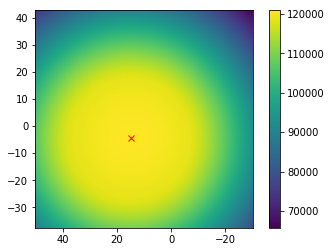

In [209]:
bb.plot_BOT()

In [210]:
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst import LsstCamMapper as camMapper

In [211]:
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

#### Focal plane coordinates of the reference pixel 
- (1000,256) in amp5 (EOtest definition) = (2304,3003) on FP coord for an 

In [212]:
xref, yref = lct.ccdPixelToFocalMm(2304, 3003,ccdid_beam)
xref, yref # FP coordinates

(2.5649999999999977, 10.015)

#### Focal plane coordinates of the beam maxium
- beam max defined in camera coordinate --> swap x and y to use DM coordinate functions (FP coord)

In [213]:
ccdid, xmax, ymax = lct.focalMmToCcdPixel(bb.properties['max_yccob'], bb.properties['max_xccob'])
print(ccdid, xmax, ymax)

R22_S11 1594.9698996655516 3497.983277591973


#### Define the shift in FP pixel coordinates between the beam maxium and the position of the CCOB

In [214]:
ref_pix_x, ref_pix_y = 2304, 3003
delta_x = ref_pix_x - xmax
delta_y = ref_pix_y -ymax
delta_x, delta_y # in FP coordinates

(709.0301003344484, -494.9832775919731)

### Read in actual data

In [215]:
#raft = 'R22'
raft = 'R30'
slot = 'S11'
ccdid_data=raft+'_'+slot
l = glob.glob(config['eo_data_path']+'/'+raft+'_'+slot+'*_eotest_results.fits')
print(l[0])
gains_fe55 = u.gains(l[0])
ccdid_data

/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6801D/fe55_analysis_BOT/v0/47706/R30_S11_6801D_eotest_results.fits


'R30_S11'

In [298]:
#pos_ccob = (0.005,0.005) # cam coordinates
#pos_ccob = (127.605,-253.895) # cam coordinates
pos_ccob = (137.615,-264.135) # cam coordinates


config['path'] = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047'
flist = glob.glob(os.path.join(config['path'],'ccob_'+led+'_'+str(pos_ccob[0])+'_'+str(pos_ccob[1])+'*/*'+ccdid_data+'*'))
flist

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_nm960_137.615_-264.135_603/MC_C_20191027_002018_R30_S11.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_nm960_137.615_-264.135_602/MC_C_20191027_002017_R30_S11.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_nm960_137.615_-264.135_601/MC_C_20191027_002016_R30_S11.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_nm960_137.615_-264.135_600/MC_C_20191027_002015_R30_S11.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6843D/BOT_acq/v0/48047/ccob_nm960_137.615_-264.135_604/MC_C_20191027_002019_R30_S11.fits']

### Make superbias frame (if needed)

In [ ]:
config['tmp_dir'] = '/home/combet/tmp_9rafts/'
bias_files = glob.glob(os.path.join(config['path']+'/','bias*/*'+ccdid_data+'*'))
#print(bias_files)
u.make_superbias_frame(config, bias_files, raft, slot)

### Read in the data (and average the frames if more than one frame in the same location)

In [299]:
tmp_file = os.path.join(config['tmp_dir'],'tmp.fits')
imutils.fits_mean_file(flist, os.path.join(config['tmp_dir'],tmp_file))
biasfile = os.path.join('/home/combet/tmp_9rafts',ccdid_data+'_sbias_image.fits')
#sensorTest.plot_flat(tmp_file, gains=gains_fe55, bias_frame = biasfile)

### Find the pixel location corresponding to the CCOB position
- CCOB position in camera coordinates --> swap x and y to use the DM coordinate tool
- Resulting position in pixel units in focal plane coordinates

In [300]:
ccdid, x_from_ccob_pos, y_from_ccob_pos = lct.focalMmToCcdPixel(pos_ccob[1], pos_ccob[0])
print(ccdid, x_from_ccob_pos, y_from_ccob_pos) # FP coordinates

R30_S11 1024.0 3003.0


- Make the mosaic CCD array (based on EOtest `sensorTest.plot_flat`)
- Result in EOtest coodinated definition

In [301]:
mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=gains_fe55, biasfile=biasfile)
np.shape(mosaic)

(4004, 4096)

### Plot the mosaic image (EOTest view)
- indicating the location of the CCOB
- the location of the beam maximum, given the offsets defined in the beam model

NB: (x,y) Focal plane coord --> (Npix_x_ccd-x,y) Eotest coordinates

(2362.9698996655516, 2508.016722408027)


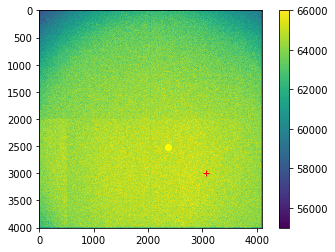

In [302]:
geom_center_pos = (np.shape(mosaic)[1]-(x_from_ccob_pos+delta_x),y_from_ccob_pos+delta_y) # EOtest coord
plt.imshow(mosaic, vmin=55000, vmax=66000)
plt.plot([np.shape(mosaic)[1]-x_from_ccob_pos],[y_from_ccob_pos], marker='+',color='red')
plt.plot([geom_center_pos[0]],[geom_center_pos[1]], marker='o',color='yellow')
plt.colorbar()
print(geom_center_pos)

In [303]:
# distance from beam center to ccd edges in mm, EOTest view
dist_to_left = geom_center_pos[0]*0.01
dist_to_top = geom_center_pos[1]*0.01
dist_to_right = (mosaic.shape[1] - geom_center_pos[0])*0.01
dist_to_bottom = (mosaic.shape[0] - geom_center_pos[1])*0.01
print(dist_to_left,dist_to_bottom,dist_to_right,dist_to_top)
print(dist_to_left+dist_to_right, dist_to_bottom+dist_to_top)

23.629698996655517 14.95983277591973 17.330301003344484 25.08016722408027
40.96 40.04


### Define the bounding box for the beam model

The beam model works in camera coordinates. So (right,left) and (top,bottom) above correspond to (top,bottom) and (right,left) in camera coordinates. Also, need to swap bottom and top (and left and right) as the beam model is inverted in both x and y compared to the image

In [304]:
bbox=(bb.properties['max_xccob']-dist_to_bottom,
       bb.properties['max_xccob']+dist_to_top,
       bb.properties['max_yccob']-dist_to_left,
       bb.properties['max_yccob']+dist_to_right)
print(bbox)
print(np.shape(mosaic))
print(-bbox[0]+bbox[1])
print(-bbox[2]+bbox[3])

(0.005000000000000782, 40.045, -28.155000000000005, 12.804999999999996)
(4004, 4096)
40.04
40.96


### Define the x and y arrays (in camera coordinates) from which to compute the cropped beam model

Need to invert the model back in both x and y

In [305]:
xarr = np.linspace(bbox[0],bbox[1],mosaic.shape[0])
yarr = np.linspace(bbox[2],bbox[3],mosaic.shape[1])
tmp = bb.beam_image['f_interp'](xarr, yarr) # interp works in cam coordinates
tmp = np.flip(np.flip(tmp,axis=0),axis=1) # invert the model in x and in y

### To get the matrix in the EOTest definition:
- Transpose
- Flip w.r.t the x-axis

In [306]:
model_eotestDef = np.flip(tmp.T, axis=1)

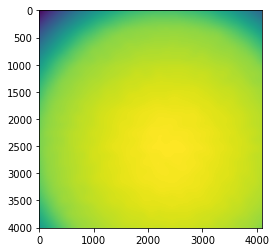

In [307]:
plt.imshow(model_eotestDef)

### Finally compute the flat flied as "beam data/beam model"

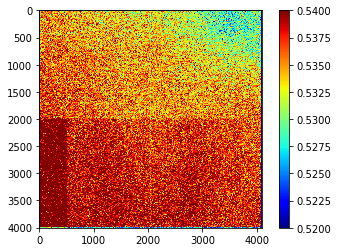

In [308]:
im = mosaic/model_eotestDef
plt.imshow(im, cmap='jet', vmin=0.52, vmax=0.54)
plt.colorbar()

In [279]:
import scipy
im_sm = scipy.ndimage.filters.gaussian_filter(im, 10, mode='constant')

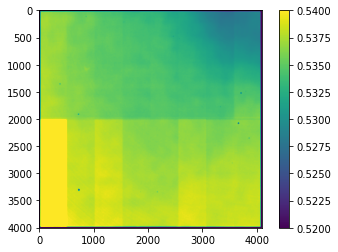

In [309]:
plt.imshow(im_sm, vmin=0.52, vmax=0.54)#/np.mean(im_sm.flatten()), cmap='jet', vmin=0.99, vmax=1.01)
plt.colorbar()

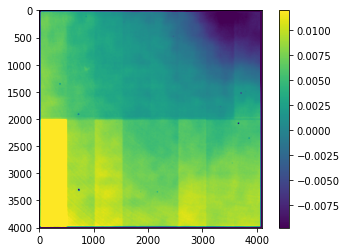

In [310]:
plt.imshow((im_sm-np.mean(im_sm.flatten()))/np.mean(im_sm.flatten()), vmin=-0.0098, vmax=0.012)
plt.colorbar()